We estimate the logistic regression coefficients for the association between Brazilian Amazon deforestation in 2000–2015 and several covariates: distance from major roads, distance from
major rivers, elevation, and slope. We compare naive imputation, classical, PPI, stratified, and stratified PPI methods.

Ground truth points are from Bullock et al: https://onlinelibrary.wiley.com/doi/abs/10.1111/gcb.15029

Map product points are from NASA GFCC: https://developers.google.com/earth-engine/datasets/catalog/NASA_MEASURES_GFCC_TC_v3

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load data

Load ground truth points (with corresponding map product labels).

In [2]:
# Binarize ground truth and map product points for deforestation 2000-2015
data = pd.read_csv('data/deforestation_ground_truth_with_covariates.csv')
data = data.dropna(subset=['canopy2000', 'canopy2015'])
data = data.rename(columns={'distance':'distance_from_roads'})
data['Types']= data[['Type1', 'Type2', 'Type3']].values.tolist()
data['Years']= data[['Year1', 'Year2', 'Year3']].values.tolist()
def find_deforestation_years(types, years):
    deforestation_indices = np.where(np.array(types) == 'Deforestation')[0].tolist()
    return np.array(years)[deforestation_indices]
data['Deforestation Years'] = data.apply(lambda x: find_deforestation_years(x.Types, x.Years), axis=1)
def deforestation_in_2000_to_2015(deforestation_years):
    if deforestation_years.size == 0:
        return False
    for year in deforestation_years:
        if year >= 2000 and year <= 2015:
            return True
    return 'different years'
data['Ground Truth Deforestation'] = data['Deforestation Years'].apply(deforestation_in_2000_to_2015)
data['Ground Truth Deforestation in 2000 to 2015'] = data['Ground Truth Deforestation'].apply(lambda x: 1 if x is True else 0)
data['ML Deforestation in 2000 to 2015 (percentage)'] = data['canopy2015']-data['canopy2000']
data['ML Deforestation in 2000 to 2015'] = data['ML Deforestation in 2000 to 2015 (percentage)'].apply(lambda x: 0 if x > -25 else 1)

C:\Users\Kerri\AppData\Local\Temp\ipykernel_12780\3630412550.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  deforestation_indices = np.where(np.array(types) == 'Deforestation')[0].tolist()


In [3]:
coordinate = [0, 1, 2, 3]
covariates = ["distance_from_roads", "distance_from_rivers", "elevation", "slope"]

The original ground truth dataset is obtained by stratified random sampling, using a stratification map (from Bullock et al https://onlinelibrary.wiley.com/doi/abs/10.1111/gcb.15029) that contains 7 strata related to deforestation status. We construct a “uniformly random sampled” ground truth dataset (with n=1386 points) by downsampling the points in each of the strata to match its area proportion.

In [4]:
# Create "destratified" dataset by resampling strata points proportionally to strata area
strata_to_number_samples = {1: 1016, 2: 94, 3: 48, 4: 96, 5: 31, 6: 5, 7: 96}
destratified_data = pd.DataFrame()
for stratum, N in strata_to_number_samples.items():
    data_stratum = data[data['Strata_Code']==stratum]
    rand_idx = np.random.RandomState(seed=0).permutation(len(data_stratum))
    destratified_data_stratum = data_stratum.iloc[rand_idx[:N]]
    destratified_data = pd.concat([destratified_data, destratified_data_stratum])
rand_idx = np.random.RandomState(seed=42).permutation(1386)
destratified_data = destratified_data.iloc[rand_idx]
destratified_data = destratified_data.reset_index(drop=True)

Y = np.array(destratified_data["Ground Truth Deforestation in 2000 to 2015"])
Yhat = np.array(destratified_data["ML Deforestation in 2000 to 2015"])
X = np.array(destratified_data[covariates])

Load ~1M uniformly random sampled, unlabeled map product points, to be used in naive imputation, PPI, and stratified PPI.

In [5]:
ml_data = pd.read_csv('data/deforestation_ml_points.csv')
ml_data = ml_data.dropna(subset=['canopy2000', 'canopy2015'])
ml_data['ML Deforestation in 2000 to 2015 (percentage)'] = ml_data['canopy2015']-ml_data['canopy2000']
ml_data['ML Deforestation in 2000 to 2015'] = ml_data['ML Deforestation in 2000 to 2015 (percentage)'].apply(lambda x: 0 if x > -25 else 1)

Yhat_unlabeled = np.array(ml_data["ML Deforestation in 2000 to 2015"])
X_unlabeled = np.array(ml_data[covariates])

# Logistic regression without stratification

We compute naive imputation, classical, and PPI 95% confidence intervals (for each covariate) for the "uniformly random sampled" dataset.

In [6]:
from ppi_py import ppi_logistic_ci, classical_logistic_ci
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [7]:
def run_ppi(X, Y, Yhat, X_unlabeled, Yhat_unlabeled, alpha):
    results = []

    # Prediction-Powered Inference

    ppi_ci = ppi_logistic_ci(
        X,
        Y,
        Yhat,
        X_unlabeled,
        Yhat_unlabeled,
        alpha=alpha,
    )

    # Classical interval
    classical_ci = classical_logistic_ci(X, Y, alpha=alpha)

    # Append results
    results += [
        pd.DataFrame(
            [
                {
                    "method": "PPI",
                    "lower": ppi_ci[0][coordinate],
                    "upper": ppi_ci[1][coordinate],
                }
            ]
        )
    ]
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Classical",
                    "lower": classical_ci[0][coordinate],
                    "upper": classical_ci[1][coordinate],
                }
            ]
        )
    ]

    # Imputed CI
    imputed_ci = classical_logistic_ci(
        X_unlabeled, Yhat_unlabeled, alpha=alpha
    )
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Imputation",
                    "lower": imputed_ci[0][coordinate],
                    "upper": imputed_ci[1][coordinate],
                }
            ]
        )
    ]

    df = pd.concat(results, axis=0, ignore_index=True)
    df["width"] = df["upper"] - df["lower"]
    df["estimate"] = 0.5*(df["upper"] + df["lower"])
    return df

In [8]:
df = run_ppi(X, Y, Yhat, X_unlabeled, Yhat_unlabeled, alpha=0.05)

Visualize computed confidence intervals

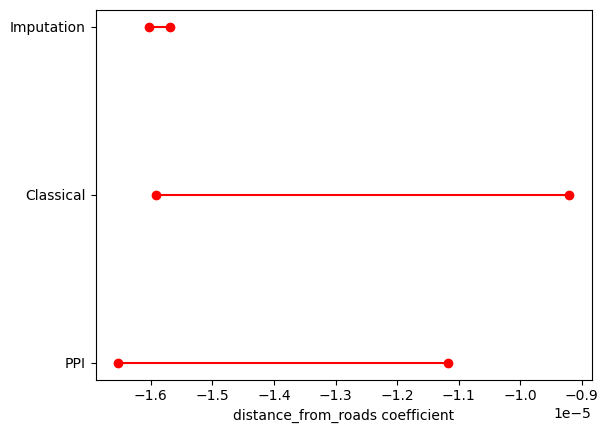

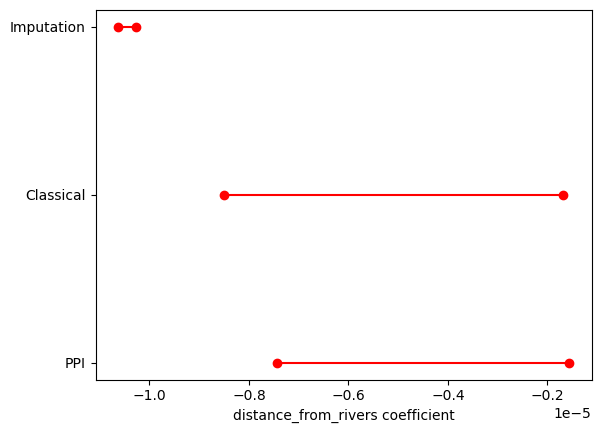

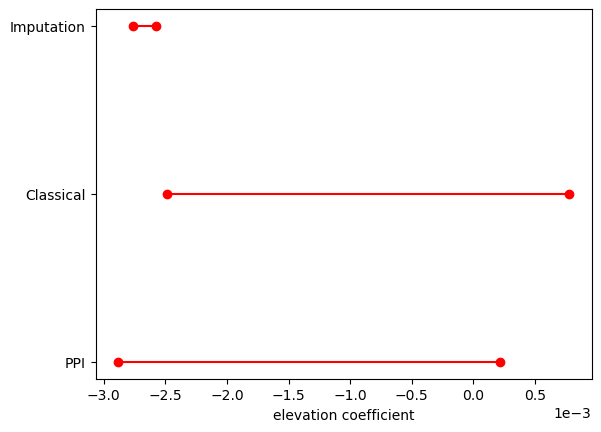

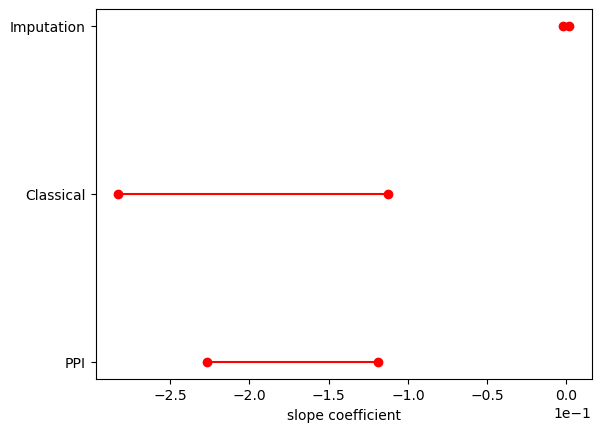

In [9]:
ppi_results = df.loc[(df['method'] == 'PPI')]
ppi_avg_estimates = ppi_results['estimate'].mean(axis=0)
ppi_avg_widths = ppi_results['width'].mean(axis=0)

classical_results = df.loc[(df['method'] == 'Classical')]
classical_avg_estimates = classical_results['estimate'].mean(axis=0)
classical_avg_widths = classical_results['width'].mean(axis=0)
original_classical_avg_widths = classical_avg_widths

imputation_estimates = df.loc[df['method']=='Imputation']['estimate'].mean(axis=0)
imputation_widths = df.loc[df['method']=='Imputation']['width'].mean(axis=0)

# https://stackoverflow.com/questions/59747313/how-can-i-plot-a-confidence-interval-in-python
covariates_to_datasets = {}
for i, column in enumerate(covariates):
    data_dict = {}
    ppi_effective_n = np.round(1386*(classical_avg_widths[i]/ppi_avg_widths[i])**2)
    data_dict['category'] = [f'PPI',
                             f'Classical',
                             'Imputation']
    data_dict['lower'] = [ppi_avg_estimates[i] - ppi_avg_widths[i]/2, classical_avg_estimates[i] - classical_avg_widths[i]/2, imputation_estimates[i] - imputation_widths[i]/2]
    data_dict['upper'] = [ppi_avg_estimates[i] + ppi_avg_widths[i]/2, classical_avg_estimates[i] + classical_avg_widths[i]/2, imputation_estimates[i] + imputation_widths[i]/2]
    data_dict['effective sample size'] = [ppi_effective_n, np.nan, np.nan]
    dataset = pd.DataFrame(data_dict)
    covariates_to_datasets[column] = dataset

    for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
        plt.plot((lower,upper),(y,y),'ro-')
    plt.yticks(range(len(dataset)),list(dataset['category']))
    plt.xlabel(f'{column} coefficient')
    #plt.legend()
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.show()

# Logistic regression with stratification

For a fair comparison, we downsample the original stratified ground truth dataset to match the size of the “uniformly random” dataset (n=1386). We also compute the point weights that will be used for stratified PPI.

In [10]:
strata_to_weights = {1: 0.732074512720708, # forest
                     2: 0.0677266963680275, # no forest
                     3: 0.0347025249349238, # deforestation
                     4: 0.0693684421320928, # D/ND
                     5: 0.02274148508064, # D/ND and deforestation
                     6: 0.00378489055612081, # regrowth
                     7: 0.0696014482075254} # buffer

In [11]:
# Downsample stratified dataset to 1386 points (to match destratified dataset)
data = data.reset_index(drop=True)
rand_idx = np.random.RandomState(seed=0).permutation(len(data))
downsampled_data = data.iloc[rand_idx[:1386]]

Y = np.array(downsampled_data["Ground Truth Deforestation in 2000 to 2015"])
Yhat = np.array(downsampled_data["ML Deforestation in 2000 to 2015"])
X = np.array(downsampled_data[covariates])

downsampled_data_strata_sizes = dict(downsampled_data["Strata_Code"].value_counts())
weights = np.array(downsampled_data['Strata_Code'].apply(lambda x: strata_to_weights[x]/downsampled_data_strata_sizes[x]))

ml_data_strata_sizes = dict(ml_data["strata"].value_counts())
weights_unlabeled = np.array(ml_data['strata'].apply(lambda x: strata_to_weights[x]/ml_data_strata_sizes[x]))

We compute stratified and stratified PPI 95% confidence intervals (for each covariate) for the stratified dataset.

In [12]:
def run_ppi_stratified(X, Y, Yhat, X_unlabeled, Yhat_unlabeled, weights, weights_unlabeled, alpha): 
    results = []

    # Stratified Prediction-Powered Inference
    ppi_stratified_ci = ppi_logistic_ci(
        X,
        Y,
        Yhat,
        X_unlabeled,
        Yhat_unlabeled,
        alpha=alpha,
        w=weights,
        w_unlabeled=weights_unlabeled,
    )

    # Stratified interval (lhat=0 so unlabeled map product points aren't used)
    stratified_ci = ppi_logistic_ci(
        X,
        Y,
        Yhat,
        X_unlabeled,
        Yhat_unlabeled,
        alpha=alpha,
        w=weights,
        w_unlabeled=weights_unlabeled,
        lhat=0,
    )

    # Append results
    results += [
        pd.DataFrame(
            [
                {
                    "method": "PPI Stratified",
                    "lower": ppi_stratified_ci[0][coordinate],
                    "upper": ppi_stratified_ci[1][coordinate],
                }
            ]
        )
    ]
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Stratified",
                    "lower": stratified_ci[0][coordinate],
                    "upper": stratified_ci[1][coordinate],
                }
            ]
        )
    ]

    df = pd.concat(results, axis=0, ignore_index=True)
    df["width"] = df["upper"] - df["lower"]
    df["estimate"] = 0.5*(df["upper"] + df["lower"])
    return df

In [13]:
df = run_ppi_stratified(X, Y, Yhat, X_unlabeled, Yhat_unlabeled, weights, weights_unlabeled, alpha=0.05)

Visualize computed confidence intervals

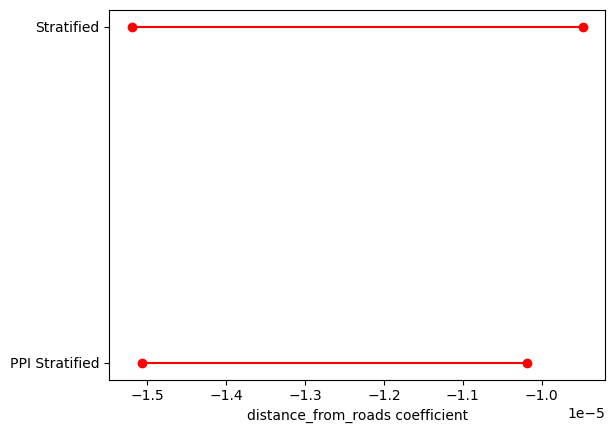

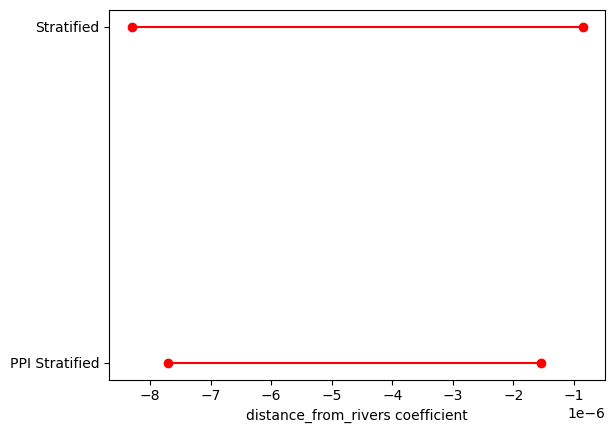

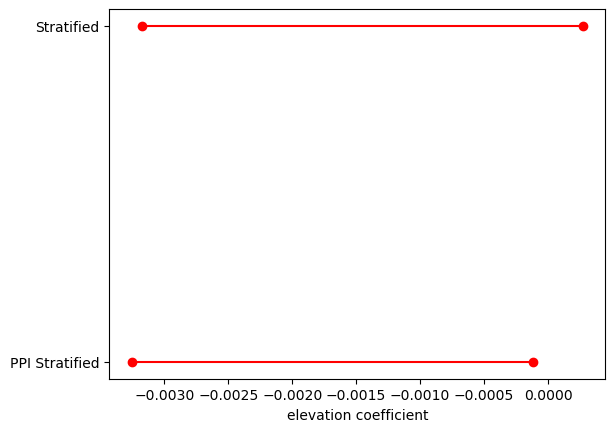

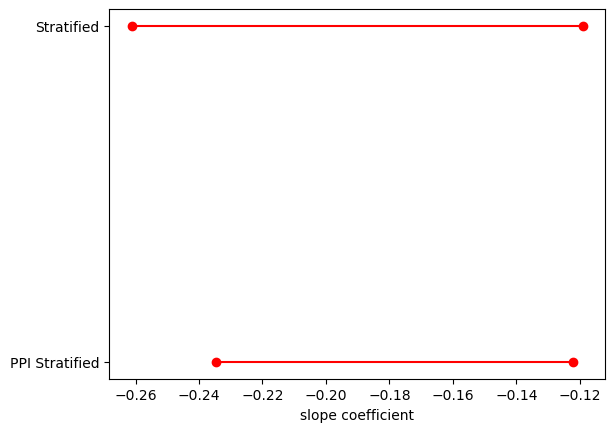

In [14]:
ppi_stratified_results = df.loc[(df['method'] == 'PPI Stratified')]
ppi_stratified_avg_estimates = ppi_stratified_results['estimate'].mean(axis=0)
ppi_stratified_avg_widths = ppi_stratified_results['width'].mean(axis=0)

stratified_results = df.loc[(df['method'] == 'Stratified')]
stratified_avg_estimates = stratified_results['estimate'].mean(axis=0)
stratified_avg_widths = stratified_results['width'].mean(axis=0)

# https://stackoverflow.com/questions/59747313/how-can-i-plot-a-confidence-interval-in-python
covariates_to_datasets2 = {}
for i, column in enumerate(covariates):
    data_dict = {}
    ppi_stratified_effective_n = np.round(1386*(original_classical_avg_widths[i]/ppi_stratified_avg_widths[i])**2)
    stratified_effective_n = np.round(1386*(original_classical_avg_widths[i]/stratified_avg_widths[i])**2)
    data_dict['category'] = [f'PPI Stratified',
                             f'Stratified',
                             ]
    data_dict['lower'] = [ppi_stratified_avg_estimates[i] - ppi_stratified_avg_widths[i]/2, stratified_avg_estimates[i] - stratified_avg_widths[i]/2]
    data_dict['upper'] = [ppi_stratified_avg_estimates[i] + ppi_stratified_avg_widths[i]/2, stratified_avg_estimates[i] + stratified_avg_widths[i]/2]
    data_dict['effective sample size'] = [ppi_stratified_effective_n, stratified_effective_n]
    dataset = pd.DataFrame(data_dict)
    covariates_to_datasets2[column] = dataset

    for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
        plt.plot((lower,upper),(y,y),'ro-')
    plt.yticks(range(len(dataset)),list(dataset['category']))
    plt.xlabel(f'{column} coefficient')
    #plt.legend()
    plt.show()

# Visualize all results in one figure

In [15]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=34)          
plt.rc('axes', titlesize=34)     
plt.rc('axes', labelsize=34)    
plt.rc('xtick', labelsize=34)    
plt.rc('ytick', labelsize=34)    
plt.rc('figure', titlesize=34)

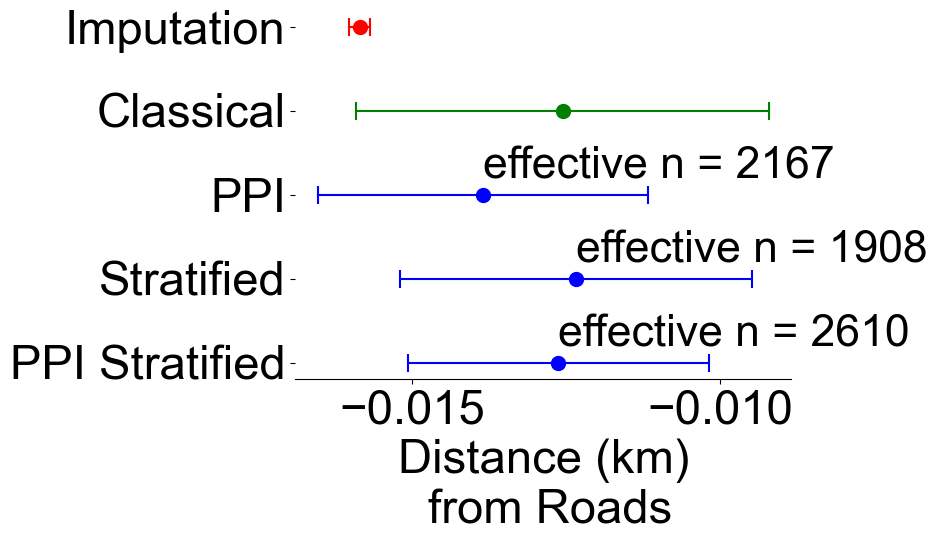

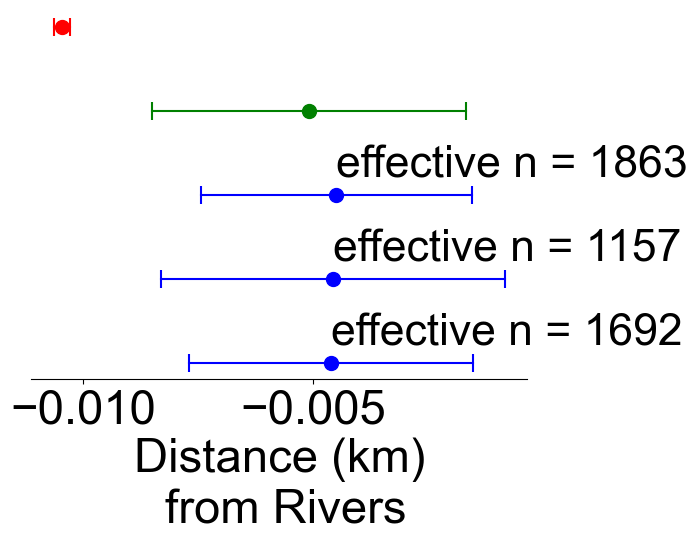

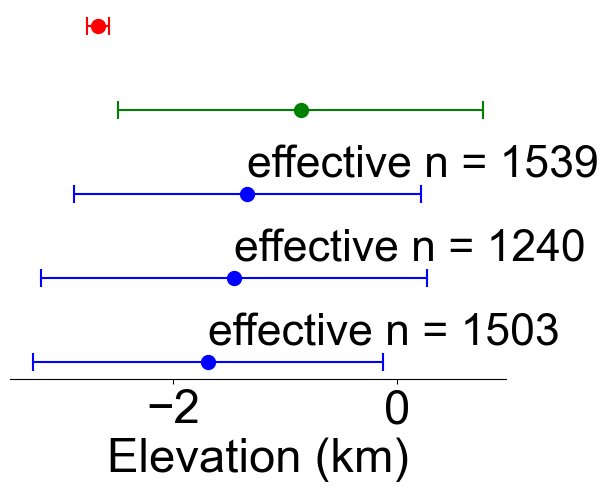

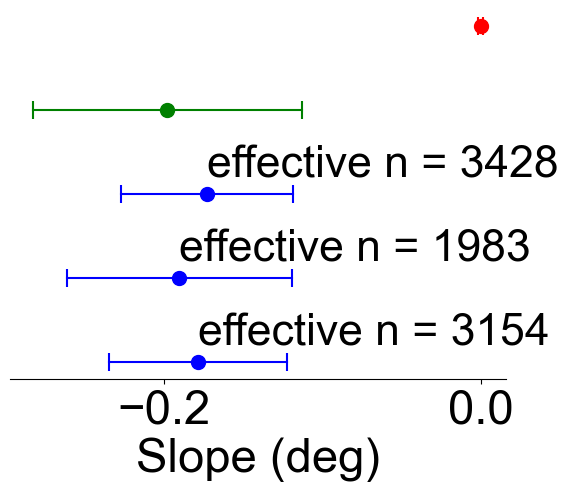

In [16]:
colors = ['blue', 'blue', 'blue', 'green', 'red']
covariates_dict = {'distance_from_roads': 'Distance (km)\n from Roads',
                   'distance_from_rivers': 'Distance (km)\n from Rivers',
                   'elevation': 'Elevation (km)', 
                   'slope': 'Slope (deg)'}
spacing = 1
for i, column in enumerate(covariates):
    dataset1 = covariates_to_datasets[column]
    dataset2 = covariates_to_datasets2[column]
    dataset_final = pd.concat([dataset2, dataset1])

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    for lower,upper,effective_n,y in zip(dataset_final['lower'],dataset_final['upper'],dataset_final['effective sample size'], range(len(dataset_final))):
        if column in ['distance_from_roads', 'distance_from_rivers', 'elevation']:
            # convert to using km (instead of m)
            lower = lower*1000
            upper = upper*1000
        plt.scatter([(lower+upper)/2], [spacing*y], color=colors[y], s=100)
        plt.scatter([lower, upper], [spacing*y, spacing*y], color=colors[y], marker='|', s=150)
        plt.plot((lower,upper),(spacing*y,spacing*y),color=colors[y])
        if y in [0, 1, 2]:
            plt.text((lower+upper)/2, spacing*(y+0.2), f'effective n = {int(effective_n)}', fontsize = 32)
    if i == 0:
        plt.yticks(spacing*np.arange(len(dataset_final)),list(dataset_final['category']))
    else:
        ax.set_yticks([])
    plt.xlabel(f'{covariates_dict[column]}')
    plt.savefig(f'output_images/deforestation_log_reg_{column}.png', dpi=300, bbox_inches='tight')
    plt.show()